In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from subprocess import call

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

%watermark -a 'Ethen' -d -t -v -p numpy,tensorflow

Ethen 2017-07-27 12:07:28 

CPython 3.5.2
IPython 5.4.1

numpy 1.13.1
tensorflow 1.1.0


# Tensorboard

In [Google’s own words](https://www.tensorflow.org/get_started/summaries_and_tensorboard): "The computations you'll use TensorFlow for - like training a massive deep neural network - can be complex and confusing. To make it easier to understand,
debug, and optimize TensorFlow programs, we've included a suite of visualization tools called TensorBoard.

The following code chunk contains a couple important concepts. When specify our computational graph, there are two tricks that can make our lives easier later on.

- The first one is giving names to our operations (a.k.a ops), e.g. `tf.add(a, b, name = 'y')`
- The other one is to group similar nodes together with `tf.name_scope()`. In the simple example below, we group all ops related to input together and all ops related to output together. It might seem like an overkill for this trivial example, but when we start to build models that are more and more complex, the debugging process can grow to be extremely daunting

Then it's about collecting summary data along the way. To elaborate, in machine learning models, we often wish to track how the objective/loss function or accuracy is changing over iterations to evaluate whether to model converged or not. With Tensorflow, we can collect these by attaching `tf.summary.scalar` ops to the nodes that output the scalar/value that we're interested in.

In [2]:
LOG_PATH = './tmp/example-1/'

with tf.name_scope('input'):
    a = tf.placeholder(tf.float32, name = 'a')
    b = tf.placeholder(tf.float32, name = 'b')

with tf.name_scope('output'):
    y = tf.add(a, b, name = 'y')

# create a summary to monitor y,
# we can create other summary by just
# adding more tf.summary.scalar
tf.summary.scalar('y_value', y)

# merge all summaries into a single op
# that generates all the summary data
# so we don't have to handle them individually
merged = tf.summary.merge_all()

with tf.Session() as sess:
    # create log writer object and pass in the log path
    # the logdir is quite important, it's the directory where all of the 
    # events will be written out. The FileWriter can optionally take a Graph 
    # in its constructor, which in our case it will be the computational graph 
    # for the current session. If it receives a Graph object, then TensorBoard
    # will visualize our graph along with tensor shape information
    writer = tf.summary.FileWriter(logdir = LOG_PATH, graph = sess.graph)

    # perform calculation, where we just keep adding numbers
    a_value = 1
    b_value = 2
    for i in range(10):
        summary, y_value = sess.run([merged, y], feed_dict = {a: a_value, b: b_value})

        # we write logs at every iteration, note that we could also consider writing
        # the summary log for every n iterations instead
        writer.add_summary(summary, i)

        a_value = b_value
        b_value = y_value
        print(y_value)

3.0
5.0
8.0
13.0
21.0
34.0
55.0
89.0
144.0
233.0


In [ ]:
# mimick command line call to lauch tensorboard
# call('tensorboard --logdir={}'.format(LOG_PATH), shell = True)
!tensorboard --logdir='./tmp/example-1/'

Now we can navigate to http://0.0.0.0:6006 to look at our tensorboard. Or we can add an additional argument to the command line call to specify the port for the tensorboard, e.g. if we add `--port=8001` then the tensorboard will be located at `localhost:8001` in our browser.

The tensorboard should look very similar to the screenshot below:

Under the scalars tab: We've only logged the value for y, so there will only be one scalar summary.

<img src="images/tensorboard_summary.png" width="60%" height="60%">

Under the graph tab, since we have grouped two ops under the input name scope, if we click on the plus sign on top of its name scope block, we can see all the ops inside that block.

<img src="images/tensorboard_graph.png" width="60%" height="60%">

Note that we might want to delete the original logdir directory if we were to re-run the code several times. Or else Tensorboard might include duplicate things in it or display warning since there will be multiple event files.

To learn more, the following link has a more comprehensive guide for configuring Tensorboard. [Tensorflow Documentation: TensorBoard: Visualizing Learning](https://www.tensorflow.org/get_started/summaries_and_tensorboard)

# Structuring Tensorflow Code

We'll re-format the [Linear Regression](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/deep_learning/softmax_tensorflow.ipynb#Linear-Regression) example that we did in the Tensorflow hello-world notebook to illustrate how we might structure our Tensorflow code into a class to make it for re-usable by others.

In [3]:
class TensorflowLinearRegression:
    """
    Linear Regression

    Parameters
    ----------
    n_iters : int, default 100
        Number of iterations to run the gradient descent optimizer

    learning_rate : float, default 0.01
        Learning rate for the optimizer

    tensorboard : str, default './graphs/linear'
        Path to store the tensorboard information

    Attributes
    ----------
    coefs_ :
        Estimated coefficients for the linear regression problem

    intercept_ :
        Independent term in the linear model
    """
    def __init__(self, n_iters = 100, learning_rate = 0.01, tensorboard = './graphs/linear'):
        self.n_iters = n_iters
        self.tensorboard = tensorboard
        self.learning_rate = learning_rate

    def fit(self, X, y):
        """
        Fit the linear regression estimator
        
        Parameters
        ----------
        X : ndarray
            Input data
            
        y : ndarray
            Input data's corresponding label
        """
        self.history_ = []

        # Clears the default graph stack and resets the global default graph;
        # this line is crucial if we want to re-run the class in interactive
        # environment such as jupyter notebook
        tf.reset_default_graph()
        self._build_graph()
        init = tf.global_variables_initializer()

        with tf.Session() as sess:
            sess.run(init)

            # use the summary FileWriter to record the loss at each epoch
            writer = tf.summary.FileWriter(self.tensorboard, sess.graph)

            for epoch in range(self.n_iters):
                feed_dict = {self._X: X, self._y: y}
                _, loss, summary = sess.run(
                    [self._train_step, self._total_loss, self._summary_op], feed_dict)

                self.history_.append(loss)
                writer.add_summary(summary, epoch)
   
            self.coefs_ = sess.run(self._W)
            self.intercept_ = sess.run(self._b)

        return self

    def predict(self, X):
        prediction = self.coefs_ * X + self.intercept_
        return prediction

    def _build_graph(self):
        """build the tensorflow computational graph"""
        
        # instead of building the entire graph in one
        # large function, we oranize into different functions;
        # hopefully the function name is already self-explanatory
        self._create_placeholders()
        self._create_variables()
        self._create_loss()
        self._create_optimizer()
        self._create_summaries()
        return self

    def _create_placeholders(self):
        # we again use name_scope to group similar ops together
        with tf.name_scope('placeholders'):
            self._X = tf.placeholder(tf.float32, name = 'data')
            self._y = tf.placeholder(tf.float32, name = 'label')

        return self

    def _create_variables(self):
        # give the model's parameter a randomized initial value
        with tf.name_scope('variables'):
            self._W = tf.Variable(np.random.randn(), tf.float32, name = 'weight')
            self._b = tf.Variable(np.random.randn(), tf.float32, name = 'bias')
        
        return self

    def _create_loss(self):
        # standard L2 loss for linear regression
        with tf.name_scope('loss'):
            pred = tf.add(self._W * self._X, self._b, name = 'prediction')
            self._total_loss = tf.reduce_mean(tf.pow(pred - self._y, 2))

        return self

    def _create_optimizer(self):
        optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
        self._train_step = optimizer.minimize(self._total_loss)
        return self

    def _create_summaries(self):
        tf.summary.scalar('loss', self._total_loss)
        self._summary_op = tf.summary.merge_all()
        return self

In [4]:
# make up some trainig data
X_train = np.asarray([3.3, 4.4, 5.5, 6.71, 6.93, 4.168, 9.779, 6.182, 7.59, 
                      2.167, 7.042, 10.791, 5.313, 7.997, 5.654, 9.27, 3.1], dtype = np.float32)
y_train = np.asarray([1.7, 2.76, 2.09, 3.19, 1.694, 1.573, 3.366, 2.596, 2.53, 
                      1.221, 2.827, 3.465, 1.65, 2.904, 2.42, 2.94, 1.3], dtype = np.float32)

linear = TensorflowLinearRegression()
linear.fit(X_train, y_train)

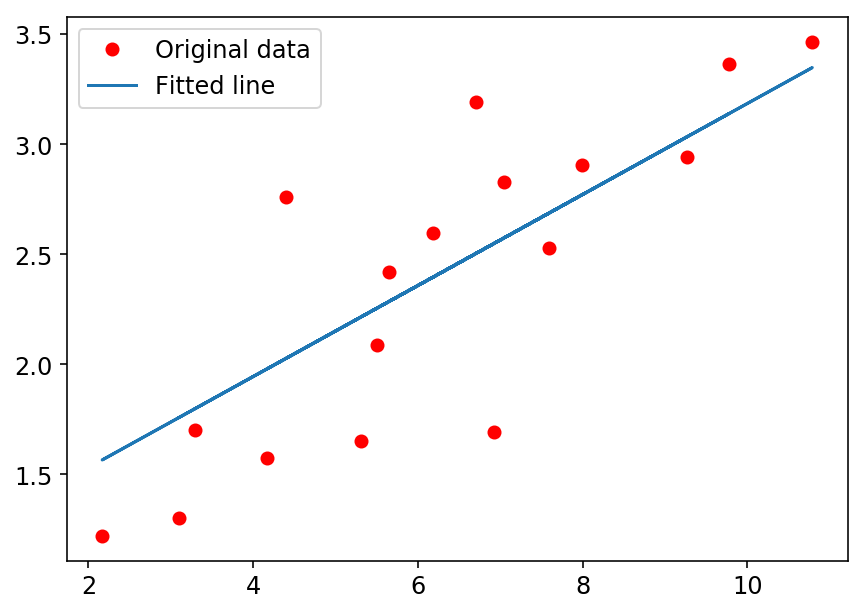

In [6]:
plt.rcParams['figure.figsize'] = 7, 5
plt.rcParams['font.size'] = 12

plt.plot(X_train, y_train, 'ro', label = 'Original data')
plt.plot(X_train, linear.coefs_ * X_train + linear.intercept_, label = 'Fitted line')
plt.legend()
plt.show()

In [ ]:
!tensorboard --logdir='./graphs/linear'

There're other ways of structuring Tensorflow models. e.g. [Blog: Structuring Your TensorFlow Models](http://danijar.com/structuring-your-tensorflow-models/). Feel free to experiment with other approaches and determine which one works better for you.

# Queues and Coordinators



In [8]:
N_SAMPLES = 1000
N_THREADS = 4

# Generating some simple data
# create 1000 random samples, each is a 1D array from the normal distribution
data = 10 * np.random.randn(N_SAMPLES, 4) + 1
data

array([[-14.00567073,  -3.76922036,  -2.7060616 ,   3.96431692],
       [  7.00221786,   5.08708196,   5.88850515,   6.10328038],
       [ 12.73872489,   8.38907223,  13.34539769,   2.38943976],
       ..., 
       [-17.6612217 ,   6.46294278, -11.81841379,  -0.79793778],
       [-20.47654248,  10.21401426,  15.42678321,   4.85220198],
       [ -2.90992765, -11.31816877,   6.06339894,  10.16476274]])

In [9]:
# create 1000 random labels of 0 and 1
target = np.random.randint(0, 2, size = N_SAMPLES) 
target[:5]

array([0, 1, 1, 0, 0])

In [10]:
queue = tf.FIFOQueue(capacity = 50, dtypes = [tf.float32, tf.int32], shapes=[[4], []])
enqueue_op = queue.enqueue_many([data, target])
data_sample, label_sample = queue.dequeue()

# create NUM_THREADS to do enqueue
queue_runner = tf.train.QueueRunner(queue, [enqueue_op] * N_THREADS)

In [11]:
# create ops that do something with data_sample and label_sample
with tf.Session() as sess:
    # create a coordinator, launch the queue runner threads.
    coord = tf.train.Coordinator()
    enqueue_threads = queue_runner.create_threads(sess, coord = coord, start = True)
    try:
        # just do 10 iterations
        for step in range(10):
            if coord.should_stop():
                break
            
            data_batch, label_batch = sess.run([data_sample, label_sample])
            print(data_batch)
            print(label_batch)
    except Exception as e:
        coord.request_stop(e)
    finally:
        coord.request_stop()
        coord.join(enqueue_threads)

[-14.00567055  -3.76922035  -2.7060616    3.96431684]
0
[ 7.00221777  5.08708191  5.88850498  6.10328054]
1
[ 12.73872471   8.38907242  13.34539795   2.38943982]
1
[ -3.1710856   -2.86932063  -5.06258965  16.92560196]
0
[ -4.90024948 -10.27263355  -2.17251301  14.52308273]
0
[  2.47634149  -0.52825028 -25.11288643  -3.74491358]
1
[  6.91693401   8.57469082  -2.95346999 -16.07347679]
1
[ -0.80032003  -5.3603406  -13.31945801  11.27880669]
0
[  1.67109442 -14.08744621  -3.43419766   0.20877868]
0
[ -1.90559328  27.41730309 -14.96559906 -18.3250103 ]
1


# Reference

- [Blog: Just another Tensorflow beginner guide (Part1)](http://liufuyang.github.io/2017/03/12/just-another-tensorflow-beginner-guide-1.html)
- [Tensorflow Documentation: TensorBoard: Visualizing Learning](https://www.tensorflow.org/get_started/summaries_and_tensorboard)
- [Note: CS 20SI Lecture note 9:  Input Pipeline](http://web.stanford.edu/class/cs20si/lectures/notes_09.pdf)